# Titanic Project with DNN

Supervised Learning. Binary classification

Predict survival on the Titanic using an artificial neural network in Keras

This project is based on a dataset containing demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic. You can view a description of this dataset on the [Kaggle website](https://www.kaggle.com/c/titanic/data), where the data was obtained.


In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import helper

helper.reproducible(seed=9)
sns.set()

Using TensorFlow backend.


## Load and prepare the data

In [2]:
data_path = 'data/titanic_data.csv'
df = pd.read_csv(data_path)
df.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


Some features (e.g. PassengerID, Name, Ticket) are irelevant to survival probabilities. Also some values are missing for key values (e.g. Age)

In [3]:
# Enhance features
from collections import Counter

#print(Counter(df["Cabin"]))
df["Cabin"] = df["Cabin"].astype(str).str[0]  # Cabin filtered to first letter (n = Nan)
print(Counter(df["Cabin"]))

Counter({'n': 687, 'C': 59, 'B': 47, 'D': 33, 'E': 32, 'A': 15, 'F': 13, 'G': 4, 'T': 1})


In [4]:
# Add new features
df['Alone'] = ((df["SibSp"] + df["Parch"]) == 0).astype(int)

# delete irrelevant features
df = df.drop(['PassengerId', 'Name', 'Ticket'], axis='columns')

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Alone
0,0,3,male,22.0,1,0,7.2500,n,S,0
1,1,1,female,38.0,1,0,71.2833,C,C,0
2,1,3,female,26.0,0,0,7.9250,n,S,1
3,1,1,female,35.0,1,0,53.1000,C,S,0
4,0,3,male,35.0,0,0,8.0500,n,S,1


In [5]:
print(df.dtypes)
df.describe()

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin        object
Embarked     object
Alone         int64
dtype: object


,Survived,Pclass,Age,SibSp,Parch,Fare,Alone
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.602694
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.489615
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


In [6]:
# Define target and features
target = ['Survived']
original_features = [f for f in list(df) if f not in target]
# df = df[original_features + target]   # order colums
# df_original = df

#numerical = list(df.select_dtypes(include=[np.number]))
numerical = ["Age", "SibSp", "Parch", "Fare"]
categorical = [f for f in list(df) if f not in numerical]

print("Numerical fields: {}".format(numerical))
print("Categorical fields: {}".format(categorical))

# Reeplace NaN values with the mean value of the feature  (better results than using the median here)
df.fillna(df.mean(), inplace=True)

df.head()

Numerical fields: ['Age', 'SibSp', 'Parch', 'Fare']
Categorical fields: ['Survived', 'Pclass', 'Sex', 'Cabin', 'Embarked', 'Alone']


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Alone
0,0,3,male,22.0,1,0,7.2500,n,S,0
1,1,1,female,38.0,1,0,71.2833,C,C,0
2,1,3,female,26.0,0,0,7.9250,n,S,1
3,1,1,female,35.0,1,0,53.1000,C,S,0
4,0,3,male,35.0,0,0,8.0500,n,S,1


Binary target: ~38% ones, ~62% ones. F1 score won't be used.

### Visualize the data

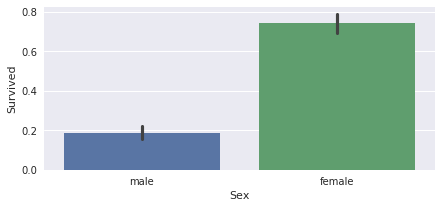

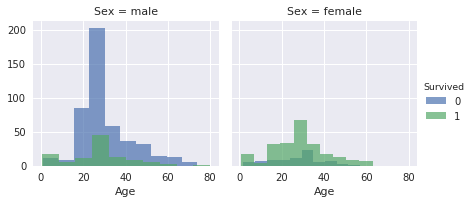

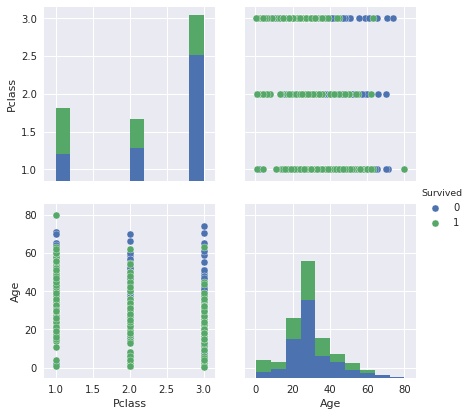

In [7]:
fig, ax = plt.subplots(figsize=[7,3])
sns.barplot(ax=ax, x='Sex',y='Survived', data=df)
sns.FacetGrid(df, col="Sex",hue="Survived", size=3).map(plt.hist, "Age", alpha=.7).add_legend();
#male_df = df[df['Sex']=='male']
sns.pairplot(df, size=3, hue='Survived', vars=['Pclass', 'Age'])


The sex of the passenger is the key feature for survival, as most women survived, followed by children under 6 approximately.

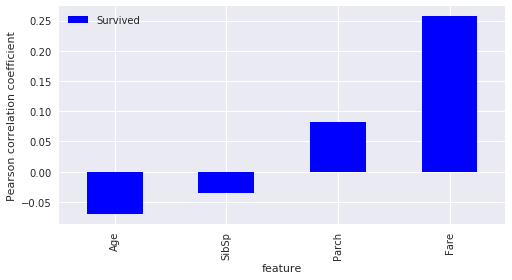

In [8]:
corr = df.corr().loc[numerical, target]

corr.plot.bar(figsize=(8, 4), colormap='winter')
plt.xlabel('feature')
plt.ylabel('Pearson correlation coefficient')
#sns.heatmap(corr, cmap="bwr")

### Select the features

In [9]:
drop = []
features = [f for f in original_features if f not in drop]

# From now use data instead of df
data = df[features + target]
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Alone,Survived
0,3,male,22.0,1,0,7.2500,n,S,0,0
1,1,female,38.0,1,0,71.2833,C,C,0,1
2,3,female,26.0,0,0,7.9250,n,S,1,1
3,1,female,35.0,1,0,53.1000,C,S,0,1
4,3,male,35.0,0,0,8.0500,n,S,1,0


### Normalize numerical variables

Shift and scale the variables such that they have zero mean and a standard deviation of 1. The scaling factors are saved so we can go backwards when we use the network for predictions.

In [10]:
scaled_features = {}
for f in numerical:
    if f in (features + target):
        mean, std = data[f].mean(), data[f].std()
        scaled_features[f] = [mean, std]
        data.loc[:, f] = (data[f] - mean)/std

data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Alone,Survived
0,3,male,-0.592148,0.432550,-0.473408,-0.502163,n,S,0,0
1,1,female,0.638430,0.432550,-0.473408,0.786404,C,C,0,1
2,3,female,-0.284503,-0.474279,-0.473408,-0.488580,n,S,1,1
3,1,female,0.407697,0.432550,-0.473408,0.420494,C,S,0,1
4,3,male,0.407697,-0.474279,-0.473408,-0.486064,n,S,1,0


### Create dummy features

In [11]:
# Only features,target one-hot encode is performed later
for f in categorical:
    if f in features:  
        dummies = pd.get_dummies(data[f], prefix=f, drop_first=False)
        data = pd.concat([data, dummies], axis=1)
        data.drop(f, axis=1, inplace=True)    
        

nn_features = [f for f in list(data) if f not in target]  # neural networks features

data = data[nn_features + target]  # reorder columns (target last)

### Split the data into training, and test sets

In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data,  test_size=0.25, random_state=9)

# Separate the data into features and target (x=features, y=target)
x_train, y_train_nc = train.drop(target, axis=1).values, train[target].values
x_test, y_test_nc = test.drop(target, axis=1).values, test[target].values
# _nc: non-categorical yet (needs one-hot encoding)


### One-hot encode the output

In [13]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train_nc, num_classes)
y_test = keras.utils.to_categorical(y_test_nc, num_classes)
print(x_train.shape ,y_train.shape)
print(x_test.shape,y_test.shape)

(668, 23) (668, 2)
(223, 23) (223, 2)


## Deep Neural Network
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 23)                552       
_________________________________________________________________
dropout_1 (Dropout)          (None, 23)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 48        
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________

Training ....
CPU times: user 2.83 s, sys: 52 ms, total: 2.88 s
Wall time: 2.96 s


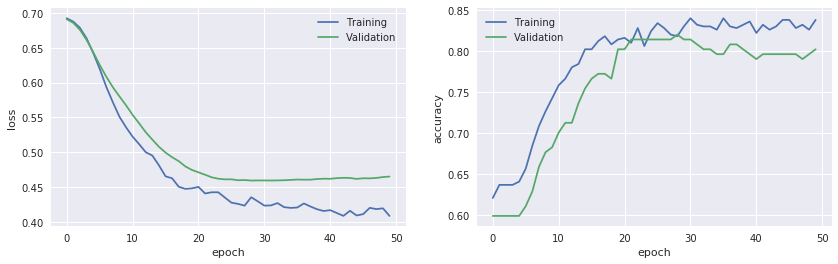


Training loss:  	0.4090
Validation loss: 	0.4654

Training accuracy: 	0.84
Validation accuracy:	0.80

Model saved at models/titanic.h5


In [14]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout

input_nodes = x_train.shape[1]
weights = keras.initializers.RandomNormal(stddev=0.001)

model = Sequential()
model.add(Dense(input_nodes, input_dim=x_train.shape[1], activation='relu',
               kernel_initializer=weights,
               bias_initializer = 'zero'))
model.add(Dropout(.2))
model.add(Dense(2,activation='softmax',
               kernel_initializer = weights,
               bias_initializer = 'zero'))
model.summary()

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('\nTraining ....')
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0)]
%time history = model.fit(x_train, y_train, epochs=1000, batch_size=64, verbose=0, validation_split=0.25, callbacks=callbacks)
helper.show_training(history)

model_path = os.path.join("models", "titanic.h5")
model.save(model_path)
print("\nModel saved at",model_path)

### Evaluate the model

In [15]:
model = keras.models.load_model(model_path)
print("Model loaded:", model_path)

score = model.evaluate(x_test, y_test, verbose=0)
print("\nTest Accuracy: {:.2f}".format(score[1]))

Model loaded: models/titanic.h5

Test Accuracy: 0.80


**Results: **<br> 

| set | size | Acccuracy  |
|---------------|-------------|------------|
| Training   | 75% training data |  0.84 |
| Validation | 25% training data |  0.81 |
| Test | 25% dataset | 0.79 |


### Make predictions

In [16]:
# input data format
print("MEDIAN: \n{}".format(df[features].median()))
df[features].head()

MEDIAN: 
Pclass     3.000000
Age       29.699118
SibSp      0.000000
Parch      0.000000
Fare      14.454200
Alone      1.000000
dtype: float64


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Alone
0,3,male,22.0,1,0,7.2500,n,S,0
1,1,female,38.0,1,0,71.2833,C,C,0
2,3,female,26.0,0,0,7.9250,n,S,1
3,1,female,35.0,1,0,53.1000,C,S,0
4,3,male,35.0,0,0,8.0500,n,S,1


In [17]:
# print(list(df[features]))
def show_survival(passengers):
    """
    input: dictionary of passengers index: features values
    ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Alone']
    """
    
    # create a dataframe for the new data only
    new_df = pd.DataFrame(columns=list(df[features]))
    for key, value in passengers.items():
        new_df.loc[key] = value    
    
    new_data = new_df
    # create dummy features    
    for f in categorical:
        if f in features:  
            dummies = pd.get_dummies(new_data[f], prefix=f, drop_first=False)
            new_data = pd.concat([new_data, dummies], axis=1)
            new_data.drop(f, axis=1, inplace=True)   
    
       
    # add missing dummies
    missing = set(nn_features) - set(new_data)  # nn_features: ordered neural network features (with dummies)
    for m in missing:
        new_data[m] = 0
        
    # order columns
    new_data = new_data[nn_features]
    
    for f in numerical:
        if f in features:
            new_data.loc[:, f] = (new_data[f] - scaled_features[f][0]) / scaled_features[f][1]    
    
    print('Survival Probabilities: \n')
    
    # make prediction
    for index, row in new_data.iterrows():    
        single_pred = model.predict(np.array([row]))    
        print('{}: \t {:.0f}%'.format(index,single_pred[0,1] * 100))

In [18]:
# single_data:['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Alone']
new_passengers = {'Average man':  [2, 'male',   30, 1, 0, 14, 'n', 'S', 0],
                  'Average woman':[2, 'female', 30, 1, 0, 14, 'n', 'S', 0],
                  'Boy 1c':       [1, 'male',    8, 0, 2, 31, 'n', 'S', 0],
                  'Boy 3c':       [3, 'male',    8, 0, 2, 8,  'n', 'S', 0],
                  'Alone Boy 3c': [3, 'male',    8, 0, 0, 8,  'n', 'S', 1]
                 }

show_survival(new_passengers)

Survival Probabilities: 

Average man: 	 19%
Average woman: 	 79%
Boy 1c: 	 50%
Boy 3c: 	 20%
Alone Boy 3c: 	 17%


The results predicted from the model confirms the impact of the sex for the survival probabilities, as well as the class and the presence of the parents for the survival of male teenagers.